# Parte 1 de la Segunda Práctica de Aprendizaje Estadístico

# Intro

En esta práctica vamos a utilizar los algoritmos de Machine Learning:

- Random Forest
- Boosting
- Support Vector Machine

Para responder a la pregunta ```¿Hasta qué punto es posible predecir la diabetes, a partir de los hábitos del sujeto?```. 

Para cada modelo, estudiaremos los hiperparámetros y elegiremos los mejores mediante Grid Search y one-standard-error

## Entendiendo la regla ***one-standard-error***

La regla one-standard-error surge para evitar el problema de “sobreajustar a la validación cruzada”: cuando probamos muchos conjuntos de hiperparámetros, el que tiene mejor media de accuracy en CV puede estar ganando simplemente por ruido estadístico y, además, suele ser el modelo más complejo. 

La idea, popularizada en el contexto de model selection (por ejemplo en Hastie, Tibshirani y Friedman), es que si varios modelos tienen rendimientos estadísticamente indistinguibles, debemos quedarnos con el más simple. Concretamente, se calcula la media y la desviación estándar del score (por ejemplo, accuracy) de cada combinación de hiperparámetros; se identifica el mejor modelo en media y su desviación estándar, se define un umbral (media score del mejor modelo -(si es accuracy)+(si es error) desviación estándar del mejor modelo), y se consideran “candidatos” todas las combinaciones cuya media esté por encima, si el score es accuracy, o por debajo, si el score es el error, de ese umbral. Entre esos candidatos, se elige el modelo más simple según algún criterio (por ejemplo, el árbol con menor max_depth, y a igualdad de eso, mayor min_samples_leaf).

Por ejemplo, estamos haciendo grid search con CV con 3 combinaciones de hiperparámetros (v1, v2, v3). Para v1, v2 y v3 la media del error y sd en CV es (5, 1), (3, 2), (6, 3) respectivamente. Escogemos la mejor combinación v2 con un error medio de 3, definimos el umbral 3 + 2 = 5. Tenemos otra combinación con error <= 5, v1. Entre v1 y v2 escogemos el modelo más simple.

Usando GridSearchCV de sklearn, esto se implementa leyendo de cv_results_ tres cosas: mean_test_score (la media del score de test en los folds de validación cruzada para cada combinación de hiperparámetros), std_test_score (la desviación estándar de esos scores) y params (la lista de diccionarios con los valores concretos de los hiperparámetros probados); con esos vectores se calcula el umbral basado en el mejor modelo, se seleccionan los índices cuyas medias estén dentro de una desviación estándar del mejor y, de ese subconjunto, se escoge el modelo más simple para finalmente reentrenarlo con todo el conjunto de entrenamiento y evaluarlo en el conjunto de test.

## Entendiendo los datos, carga de librerías

In [1]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
import seaborn as sns

diabetes _ binary _ 5050split _ health _ indicators _ BRFSS2015.csv is a clean dataset of 70,692 survey responses to the CDC's BRFSS2015. It has an equal 50-50 split of respondents with no diabetes and with either prediabetes or diabetes. The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes. This dataset has 21 feature variables and is balanced.

In [2]:
df = pd.read_csv('diabetesBRFSS2015.csv')

In [3]:
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

El dataset no contiene nulos, nos viene dado ya limpio, la variable que queremos predecir es **Diabetes_binary** (0 = no tiene diabetes, 1 = tiene diabetes)

In [5]:
for c in df.columns:
    print(f'Columna {c}, valores únicos: {df[c].unique()}')

Columna Diabetes_binary, valores únicos: [0. 1.]
Columna HighBP, valores únicos: [1. 0.]
Columna HighChol, valores únicos: [0. 1.]
Columna CholCheck, valores únicos: [1. 0.]
Columna BMI, valores únicos: [26. 28. 29. 18. 31. 32. 27. 24. 21. 58. 30. 20. 22. 38. 40. 25. 36. 47.
 19. 37. 41. 23. 34. 35. 42. 17. 33. 44. 15. 52. 69. 56. 45. 39. 92. 53.
 98. 50. 46. 79. 48. 16. 63. 72. 54. 49. 68. 43. 84. 73. 76. 55. 51. 75.
 57. 60. 12. 77. 82. 67. 71. 61. 14. 81. 59. 86. 13. 87. 65. 95. 89. 62.
 64. 66. 85. 70. 83. 80. 78. 74.]
Columna Smoker, valores únicos: [0. 1.]
Columna Stroke, valores únicos: [0. 1.]
Columna HeartDiseaseorAttack, valores únicos: [0. 1.]
Columna PhysActivity, valores únicos: [1. 0.]
Columna Fruits, valores únicos: [0. 1.]
Columna Veggies, valores únicos: [1. 0.]
Columna HvyAlcoholConsump, valores únicos: [0. 1.]
Columna AnyHealthcare, valores únicos: [1. 0.]
Columna NoDocbcCost, valores únicos: [0. 1.]
Columna GenHlth, valores únicos: [3. 1. 2. 4. 5.]
Columna MentHlth,

Tenemos variables binarias y numéricas, todas son de tipo ```float64```. No se aprecian valores erroneos (como negativos en edad y cosas así).

Definimos los conjuntos de predictores, variable objetivo, entrenamiento y testeo. Los vamos a usar en los diferentes modelos

In [6]:
X = df.drop("Diabetes_binary", axis=1) 
y = df["Diabetes_binary"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Creamos un objeto de validación cruzada que vamos a utilizar a lo largo de todo el notebook

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest Classifier

## Descripción del algoritmo y modelo

### Explicar brevemente el tipo de modelo que genera el algoritmo, y cuál es la estrategia de dicho algoritmos para construir el modelo.

Random Forest es un algoritmo de aprendizaje supervisado que construye un modelo formado por un conjunto (bosque) de árboles de decisión que combina sus predicciones para obtener un modelo más preciso.

Random Forest es una variación de bagging (Bootstrap Aggregating):

1. Se generan múltiples subconjuntos del dataset mediante muestreo con reemplazo (bootstrap).
2. Para cada subconjunto se entrena un árbol de decisión independiente.
3. En cada división del árbol, solo se considera un subconjunto aleatorio de variables, lo que introduce diversidad entre los árboles.
4. La predicción final se obtiene:
Clasificación: por votación mayoritaria.\
Regresión: mediante el promedio de las predicciones.

Esta combinación reduce la varianza, evita el sobreajuste y mejora la capacidad de generalización frente a un único árbol de decisión.

### Indicar si el algoritmo en cuestión tiene algún requisito en cuanto a si se han de preprocesar los datos (e.g. escalado, imputación de valores nulos, etc.) y cómo.

Random Forest es un modelo poco exigente en preprocesamiento, es bastante robusto a outliers y no es necesario escalar las variables al tratarse de árboles (no se basan en distancias). Lo único transformar variables categóricas a formato numérico, usando label encoding o one-hot encoding, y no introducir datos con valores nulos, eliminarlos o imputar con diferentes técnicas como imputación usando la media o más avanzadas. En ambos casos no nos tenemos que preocupar porque los datos ya están procesados.

### Identificar y explicar cada uno de sus hiperparámetros

Vamos a estudiar los hiperparámetros como vienen definidos en sklearn, ya que es esta la implementación que vamos a usar. Si vamos a la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) vemos que tiene bastantes parámetros. No los vamos a estudiar todos, vamos a definir los más importantes que optimizaremos con la grid search.

- ```n_estimators``` Uno de los hiperparámetros más básicos, define el número de árboles que va a formar nuestro bosque. Recordar que el este modelo no sobreajusta por muchos árboles que añadamos.
- ```max_depth``` Profundidad máxima de cada árbol, a mayor profundidad mayor varianza, a menor profundidad mayor sesgo.
- ```min_samples_split``` Número mínimo de muestras que debe tener un nodo para que se intente dividir. Valores más altos evitan que el árbol genere muchas ramas a partir de muy pocos datos, reducen la varianza y hacen el modelo más simple (más sesgo).
- ```min_samples_leaf``` Número mínimo de muestras que debe tener una hoja. Obliga a que las hojas representen grupos de cierta talla y no casos casi individuales. Aumentar este valor suaviza las decisiones del modelo, reduce el sobreajuste y hace las predicciones más estables, a costa de algo más de sesgo.
- ```max_features``` Número de predictores que vamos a escoger aleatoriamente a la hora de crear cada árbol. Este hiperparámetro no lo vamos a optimizar con el grid search, lo vamos a dejar en el valor por defecto "sqrt" (raíz cuadrada del número original de predictores), ya que tenemos un número suficiente grande de predictores.

## Estrategia para la generación de valores de hiperparámetros para el grid

Dado que Random Forest es un modelo relativamente barato de entrenar, vamos a aplicar una estrategia de búsqueda exhaustiva en dos fases para la selección de hiperparámetros:

1. Primera fase (exploratoria):\
Se aplica GridSearchCV sobre un conjunto amplio de valores para los hiperparámetros principales, cubriendo modelos de distinta complejidad. El objetivo de esta fase es identificar la región del espacio de hiperparámetros donde se encuentran los modelos con mejor rendimiento. A partir de los resultados se seleccionan los 2–3 modelos con mayor desempeño medio en validación cruzada.

2. Segunda fase (refinamiento):\
Se realiza un nuevo GridSearchCV restringiendo el espacio de búsqueda a valores cercanos a los hiperparámetros óptimos identificados en la fase anterior. Sobre este segundo grid se aplica el criterio de one-standard-error, seleccionando el modelo más simple cuyo rendimiento sea estadísticamente indistinguible del mejor, con el objetivo de favorecer la generalización.

## Ejecución

### Primera fase de selección de hiperparámetros

In [9]:
df.shape

(70692, 22)

Tenemos 70000 instancias y 21 variables sin contar la objetivo. Teniendo eso en cuenta vamos a elegir los valores iniciales de la exploración

In [10]:
grid_1_rf = {
  'n_estimators': [50, 100, 300, 500, 800],
   'max_depth': [5, 10, 20, None],
   'min_samples_leaf': [30, 70, 350, 700], # Tenemos bastantes datos, por lo que debemos evitar hojas con pocas instancias. (N * 0.001, N * 0.005, N * 0.01)
   'min_samples_split': [60, 140, 700, 1400] # Relacionamos min_samples_leaf con min_samples_split min_samples_split = 2 × min_samples_leaf
}

Como esta primera fase no es para seleccionar el modelo final, simplemente es para ver en que rangos se encuentran los mejores hiperparámetros, no vamos a dividir en train y test, vamos a hacer grid search con todos los datos. Ya en la segunda fase si que dividiremos train y test

In [11]:
base_random_forest = RandomForestClassifier(
    random_state=42,
    max_features="sqrt",
    n_jobs=1
)


In [12]:
grid_search_1_rf = GridSearchCV(
    estimator=base_random_forest,
    param_grid=grid_1_rf,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [13]:
grid_search_1_rf.fit(X, y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END max_depth=5, min_samples_leaf=30, min_samples_split=60, n_estimators=50; total time=   1.3s
[CV] END max_depth=5, min_samples_leaf=30, min_samples_split=60, n_estimators=50; total time=   1.3s
[CV] END max_depth=5, min_samples_leaf=30, min_samples_split=60, n_estimators=50; total time=   1.3s
[CV] END max_depth=5, min_samples_leaf=30, min_samples_split=60, n_estimators=50; total time=   1.4s
[CV] END max_depth=5, min_samples_leaf=30, min_samples_split=60, n_estimators=50; total time=   1.4s
[CV] END max_depth=5, min_samples_leaf=30, min_samples_split=60, n_estimators=100; total time=   2.5s
[CV] END max_depth=5, min_samples_leaf=30, min_samples_split=60, n_estimators=100; total time=   2.5s
[CV] END max_depth=5, min_samples_leaf=30, min_samples_split=60, n_estimators=100; total time=   2.6s
[CV] END max_depth=5, min_samples_leaf=30, min_samples_split=60, n_estimators=100; total time=   2.7s
[CV] END max_depth=5, m

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'min_samples_leaf': [30, 70, 350, 700],
                         'min_samples_split': [60, 140, 700, 1400],
                         'n_estimators': [50, 100, 300, 500, 800]},
             scoring='accuracy', verbose=2)

Top N mejores modelos

In [14]:
n = 15
results_1_rf = grid_search_1_rf.cv_results_
top_3_idx = np.argsort(-results_1_rf["mean_test_score"])[:n]

print(f"\nTop {n} modelos:")
for idx in top_3_idx:
    print(f"Accuracy: {results_1_rf['mean_test_score'][idx]:.4f} ± {results_1_rf['std_test_score'][idx]:.4f} | Params: {results_1_rf['params'][idx]}")


Top 15 modelos:
Accuracy: 0.7509 ± 0.0019 | Params: {'max_depth': None, 'min_samples_leaf': 30, 'min_samples_split': 60, 'n_estimators': 500}
Accuracy: 0.7508 ± 0.0018 | Params: {'max_depth': None, 'min_samples_leaf': 30, 'min_samples_split': 60, 'n_estimators': 300}
Accuracy: 0.7508 ± 0.0019 | Params: {'max_depth': 20, 'min_samples_leaf': 30, 'min_samples_split': 60, 'n_estimators': 500}
Accuracy: 0.7507 ± 0.0018 | Params: {'max_depth': 20, 'min_samples_leaf': 30, 'min_samples_split': 60, 'n_estimators': 300}
Accuracy: 0.7507 ± 0.0022 | Params: {'max_depth': None, 'min_samples_leaf': 30, 'min_samples_split': 60, 'n_estimators': 800}
Accuracy: 0.7506 ± 0.0017 | Params: {'max_depth': 20, 'min_samples_leaf': 30, 'min_samples_split': 60, 'n_estimators': 100}
Accuracy: 0.7506 ± 0.0023 | Params: {'max_depth': None, 'min_samples_leaf': 30, 'min_samples_split': 140, 'n_estimators': 100}
Accuracy: 0.7505 ± 0.0027 | Params: {'max_depth': 20, 'min_samples_leaf': 30, 'min_samples_split': 140, 'n

In [15]:
%%capture best_models
n = 15
results_1_rf = grid_search_1_rf.cv_results_
top_3_idx = np.argsort(-results_1_rf["mean_test_score"])[:n]

print(f"\nTop {n} modelos:")
for idx in top_3_idx:
    print(f"Accuracy: {results_1_rf['mean_test_score'][idx]:.4f} ± {results_1_rf['std_test_score'][idx]:.4f} | Params: {results_1_rf['params'][idx]}")

Guardamos la salida para no tener que ejecutar esta parte más

In [16]:
with open("mejores_modelos_primera_fase.txt", "a") as f:
    f.write(best_models.stdout)

**Conclusiones de la primera fase**

- Los 15 mejores modelos tienen todos un ```min_samples_leaf``` de 30. Por lo que ese hiperparámetro no lo vamos a estudiar más. 
- ```min_samples_split``` varía entre 60 y 140, parece un poco mejor 60.
- Para ```max_depth``` los valores que más aparecen son None y 20, los dos más altos
- ```n_estimators``` no parece que sea el hiperparámetro que más determine la calidad del modelo, el valor que más se repite entre los 15 mejores es 800, pero los 4 mejores modelos tienen 500 y 300. Podemos descartar los dos valores más pequeños porque son los que menos aparecen

En conjunto, la combinación ```min_samples_leaf``` = 30 ```min_samples_split``` = 60 parece sin duda la mejor, y los otros dos hiperparámetros pueden variar un poco más, quedandose ```max_depth``` entre 20 y None



### Segunda fase de selección de hiperparámetros

Definimos el grid definitivo teniendo en cuenta los resultados de la fase anterior

In [17]:
grid_2_rf = {
  'n_estimators': [300, 500, 800],
   'max_depth': [20, None],
   'min_samples_leaf': [20, 30, 40], # Estudiamos valores en torno a 30 que parecen ser los mejores
   'min_samples_split': [40, 60, 80] 
}

In [18]:
grid_search_2_rf = GridSearchCV(
    estimator=base_random_forest,
    param_grid=grid_2_rf,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [19]:
grid_search_2_rf.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=40, n_estimators=300; total time=  16.2s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=40, n_estimators=300; total time=  16.9s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=40, n_estimators=300; total time=  17.4s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=40, n_estimators=300; total time=  17.7s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=40, n_estimators=300; total time=  18.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=40, n_estimators=500; total time=  31.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=40, n_estimators=500; total time=  31.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=40, n_estimators=500; total time=  31.6s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=40, n_estimators=500; total time=  31.8s
[CV] END ma

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [20, None],
                         'min_samples_leaf': [20, 30, 40],
                         'min_samples_split': [40, 60, 80],
                         'n_estimators': [300, 500, 800]},
             scoring='accuracy', verbose=2)

Recordando la regla **one-standar-error**:
```
Por ejemplo, estamos haciendo grid search con CV con 3 combinaciones de hiperparámetros (v1, v2, v3). Para v1, v2 y v3 la media del error y sd en CV es (5, 1), (3, 2), (6, 3) respectivamente. Escogemos la mejor combinación v2 con un error medio de 3, definimos el umbral 3 + 2 = 5. Tenemos otra combinación con error <= 5, v1. Entre v1 y v2 escogemos el modelo más simple.

Usando GridSearchCV de sklearn, esto se implementa leyendo de cv_results_ tres cosas: mean_test_score (la media del score de test en los folds de validación cruzada para cada combinación de hiperparámetros), std_test_score (la desviación estándar de esos scores) y params (la lista de diccionarios con los valores concretos de los hiperparámetros probados); con esos vectores se calcula el umbral basado en el mejor modelo, se seleccionan los índices cuyas medias estén dentro de una desviación estándar del mejor y, de ese subconjunto, se escoge el modelo más simple para finalmente reentrenarlo con todo el conjunto de entrenamiento y evaluarlo en el conjunto de test.
```

Para determinar si un modelo Random Forest es más simple que otro nos vamos a fijar en sus hiperparámetros. 
- ```n_estimators``` A menos número de árboles más simple
- ```max_depth``` A menor profundidad más simple
- ```min_samples_split``` A mayor más simple
- ```min_samples_leaf``` A mayor más simple

In [20]:
results_2_rf = grid_search_2_rf.cv_results_
means_2_rf = results_2_rf["mean_test_score"]
stds_2_rf = results_2_rf["std_test_score"]
params_2_rf = results_2_rf["params"]

# índice del modelo con mejor accuracy medio
idx_best = np.argmax(means_2_rf)
best_mean = means_2_rf[idx_best]
best_std = stds_2_rf[idx_best]
threshold = best_mean - best_std  # one-standard-error

print(f"\nMejor modelo (fase 2): accuracy={best_mean:.4f} ± {best_std:.4f} con parámetros: {params_2_rf[idx_best]}")
print(f"Umbral one-standard-error: {threshold:.4f}")

# Candidatos cuyo accuracy >= threshold
candidate_indices_2_rf = [i for i, m in enumerate(means_2_rf) if m >= threshold]


Mejor modelo (fase 2): accuracy=0.7502 ± 0.0019 con parámetros: {'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 300}
Umbral one-standard-error: 0.7483


In [21]:
for idx in candidate_indices_2_rf:
    print(params_2_rf[idx])
    print('-'*20)

{'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 300}
--------------------
{'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 500}
--------------------
{'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 800}
--------------------
{'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 60, 'n_estimators': 300}
--------------------
{'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 60, 'n_estimators': 500}
--------------------
{'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 60, 'n_estimators': 800}
--------------------
{'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 80, 'n_estimators': 300}
--------------------
{'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 80, 'n_estimators': 500}
--------------------
{'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 80, 'n_estimators': 800}
--------------------
{'max_depth': 20, '

Como la lista de candidatos está ordenada de manera ascendente para cada parámetro, para encontrar el modelo más simple simplemente buscamos el que tenga menor ```max_depth``` y ```n_estimators``` y menor ```main_samples_leaf``` y ```max_samples_split```. En este caso el modelo:\
```{'max_depth': 20, 'min_samples_leaf': 40, 'min_samples_split': 80, 'n_estimators': 300}```

In [22]:
best_rf = RandomForestClassifier(
    **{'max_depth': 20, 'min_samples_leaf': 40, 'min_samples_split': 80, 'n_estimators': 300},
    random_state=42,
    max_features="sqrt",
    n_jobs=-1
)

best_rf.fit(X_train, y_train)

y_pred_test_2_rf = best_rf.predict(X_test)
test_accuracy_2_rf = accuracy_score(y_test, y_pred_test_2_rf)
test_error_2_rf = 1.0 - test_accuracy_2_rf

print("\n=== Rendimiento en TEST ===")
print(f"Accuracy en test: {test_accuracy_2_rf:.4f}")
print(f"Error en test:    {test_error_2_rf:.4f}")


=== Rendimiento en TEST ===
Accuracy en test: 0.7490
Error en test:    0.2510


El error en el conjunto de test es del **0.2510**, aproximadamente nuestro modelo falla un **25%** de las veces

# (Hist) Gradient Boosting Classifier

## Descripción del algoritmo y modelo

### Explicar brevemente el tipo de modelo que genera el algoritmo, y cuál es la estrategia de dicho algoritmos para construir el modelo.

Gradient Boosting Classifier (GB) es también un algoritmo de aprendizaje supervisado basado en un conjunto de árboles de decisión, pero no funciona en paralelo como Random Forest, sino de forma secuencial.

Es una implementación del método de Boosting, la idea de este método es entrenar árboles de manera secuencial usando los errores del árbol anterior. De manera que al sumar todas las predicciones se acerca al valor real. Los pasos del método de Boosting son:

1. Se entrena un primer modelo sencillo (por ejemplo, un árbol pequeño) sobre los datos.
2. Se calculan los errores/residuos de este modelo (en clasificación, van ligados al gradiente de una función de pérdida, como log-loss).
3. Se entrena un nuevo árbol para predecir esos residuos/gradientes (es decir, para corregir lo que el modelo actual está haciendo mal).
4. Se añade este nuevo árbol al modelo, pero escalado por una tasa de aprendizaje (learning rate).
5. Se repiten los pasos 2–4, añadiendo árboles hasta llegar al número de iteraciones o hasta que el modelo deje de mejorar.
6. Una vez entrenados los árboles, la predicción es la suma de la salida de cada modelo por la tasa de aprendizaje.


Sin embargo, si nos vamos a la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) de GB, veremos que para datasets con un número de instancias mayor a 10000 (como es nuestro caso) nos recomiendan usar [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) HGB, al ser una variente de Boosting mucho más rápida para estos casos, además de soportar valores nulos y categóricas, aunque esta última funcionalidad no la vamos a aprovechar.

La diferencia de HGB respecto a GBC que lo hace más rápido es que tienen un paso previo de binning. Antes de entrenar, cada feature se discretiza en hasta ```max_bins``` bins enteros (típicamente 256), lo que reduce los candidatos para cada split y acelera el entrenamiento, ya que el árbol solo puede dividir regiones en los bordes del bin. Además, se reserva un bin extra para valores missing. Esto permite construir splits usando histogramas en vez de valores continuos ordenados. Esto se podría considerar un método de regularización, ya que estamos regulando o restringiendo el modelo para que no se ajuste demasiado a los datos.


### Indicar si el algoritmo en cuestión tiene algún requisito en cuanto a si se han de preprocesar los datos (e.g. escalado, imputación de valores nulos, etc.) y cómo.

HGB, al basarse en árboles de decisión, tiene requisitos parecidos a Random Forest, aunque como ya hemos comentado mtiene características mejoradas:

- No necesita escalado de variables (standard scaler, min-max, etc.), porque los árboles no usan distancias.
- Variables categóricas: No hace falta ninguna transformación, solamente necesitas marcarlas como categóricas para que el modelo lo sepa.
- Valores nulos: Admite valores nulos.
- Outliers: No hace falta ningún tratamiento, como ya comentamos los árboles toman decisiones por umbrales y no por distancias, así que suelen ser relativamente robustos a valores extremos. En HGB, el binning agrupa los valores en intervalos, lo que puede reducir sensibilidad a pequeñas variaciones/extremos aislados. Lo único si los outliers son errores de medición o valores imposibles si que obviamente conviene revisarlos, en nuestro caso no nos tenemos que preocupar.

### Identificar y explicar cada uno de sus hiperparámetros

```max_iter``` Número máximo de iteraciones del boosting. En clasifiación binaria es el máximo nº de árboles, en multiclase se construye un arbol por cada clase en cada iteración. El algoritmo está implementado de manera que si no detecta una mejora en varias iteraciones pare de construir el modelo (early stopping), por lo que no nos tenemos que preocupar mucho por el sobreajuste si añadimos max_iter de más y lo tenemos activado. (100 por defecto)

```learning_rate``` factor que escala la contribución de cada árbol. Suele estar relacionado con max_iter (LR más pequeño, normalmente necesitas más iteraciones). (0.1 por defecto)

```max_leaf_nodes``` Límite del número de hojas por árbol (control directo de complejidad). Menos hojas → árboles más simples (más sesgo, menos varianza) y más rápido. (31 por defecto)

```max_bins``` Nº máximo de bins del binning. Menos bins = splits más “toscos” (más regularización). En general sklearn recomienda usar muchos. (255 por defecto y máximo permitido)

```early_stopping``` Controla si se usa parada temprana. En 'auto' se activa si n_samples > 10000 o si pasas X_val, y_val a fit. Es importante entender como funciona el early stopping porque si no lo manejamos con cuidado nos puede llevar a problemas. Para detectar si en cada iteración el modelo mejora o no necesita medir el rendimiento en datos que no se esten usando para entrenar, es por eso que internamente divide los datos en train y validación. Si hacemos validación cruzada estaríamos introduciendo una segunda validación interna dentro de cada fold, lo que empeora la calidad del grid search (tenemos menos datos para entrenar, fuente extra de aleatoriedad, coste computacional extra...). Es por eso que a la hora de hacer grid search debe de estar desactivado.


## Estrategia para la generación de valores de hiperparámetros para el grid

Vamos a seguir la misma estrategia en dos fases que usamos para random forest, una primera fase en la que exploraremos un conjunto variable de hiperparámetros y una segunda fase en la que afinaremos sobre los hiperparámetros que mejor resultado dieron en la fase anterior.

Para elegir los valores iniciales en la primera fase vamos a guiarnos por los valores por defecto de los parámetros en scikit-learn.

## Ejecución

### Primera fase de selección de hiperparámetros

In [23]:
df.shape

(70692, 22)

In [24]:
grid_1_hgb = {
  'max_iter': [50, 100, 200, 300],
  'learning_rate': [0.1, 0.01, 0.001],
  'max_leaf_nodes': [20, 31, 50, 90],
  'max_bins': [100, 200, 255]
}

In [25]:
# Modelo base para el GridSearch
hgb_base = HistGradientBoostingClassifier(
    random_state=42,
    early_stopping=False  # importante: en GridSearchCV (con CV externo) mejor desactivarlo
)

In [26]:
grid_search_1_hgb = GridSearchCV(
    estimator=hgb_base,
    param_grid=grid_1_hgb,
    scoring='accuracy', 
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [27]:
grid_search_1_hgb.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=20; total time=   1.4s
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=20; total time=   1.4s
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=20; total time=   1.4s
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=20; total time=   1.5s
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=20; total time=   1.5s
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=31; total time=   1.6s
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=31; total time=   1.6s
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=31; total time=   1.6s
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=31; total time=   1.7s
[CV] END learning_rate=0.1, max_bins=100, max_iter=50, max_leaf_nodes=31; total time=   1.7s
[CV] EN

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=HistGradientBoostingClassifier(early_stopping=False,
                                                      random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_bins': [100, 200, 255],
                         'max_iter': [50, 100, 200, 300],
                         'max_leaf_nodes': [20, 31, 50, 90]},
             scoring='accuracy', verbose=2)

In [28]:
n = 15
results_1_hgb = grid_search_1_hgb.cv_results_
top_3_idx = np.argsort(-results_1_hgb["mean_test_score"])[:n]

print(f"\nTop {n} modelos:")
for idx in top_3_idx:
    print(f"Accuracy: {results_1_hgb['mean_test_score'][idx]:.4f} ± {results_1_hgb['std_test_score'][idx]:.4f} | Params: {results_1_hgb['params'][idx]}")


Top 15 modelos:
Accuracy: 0.7531 ± 0.0011 | Params: {'learning_rate': 0.1, 'max_bins': 200, 'max_iter': 50, 'max_leaf_nodes': 50}
Accuracy: 0.7531 ± 0.0011 | Params: {'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 50}
Accuracy: 0.7531 ± 0.0011 | Params: {'learning_rate': 0.1, 'max_bins': 100, 'max_iter': 50, 'max_leaf_nodes': 50}
Accuracy: 0.7527 ± 0.0012 | Params: {'learning_rate': 0.1, 'max_bins': 200, 'max_iter': 100, 'max_leaf_nodes': 20}
Accuracy: 0.7527 ± 0.0012 | Params: {'learning_rate': 0.1, 'max_bins': 100, 'max_iter': 100, 'max_leaf_nodes': 20}
Accuracy: 0.7527 ± 0.0012 | Params: {'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 100, 'max_leaf_nodes': 20}
Accuracy: 0.7524 ± 0.0011 | Params: {'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 200, 'max_leaf_nodes': 20}
Accuracy: 0.7524 ± 0.0011 | Params: {'learning_rate': 0.1, 'max_bins': 100, 'max_iter': 200, 'max_leaf_nodes': 20}
Accuracy: 0.7524 ± 0.0011 | Params: {'learning_rate': 0.1, 'max_bi

In [29]:
%%capture best_models_hgb
n = 15
results_1_hgb = grid_search_1_hgb.cv_results_
top_3_idx = np.argsort(-results_1_hgb["mean_test_score"])[:n]

print(f"\nTop {n} modelos:")
for idx in top_3_idx:
    print(f"Accuracy: {results_1_hgb['mean_test_score'][idx]:.4f} ± {results_1_hgb['std_test_score'][idx]:.4f} | Params: {results_1_hgb['params'][idx]}")

In [30]:
with open("mejores_modelos_primera_fase_HGB.txt", "a") as f:
    f.write(best_models_hgb.stdout)

**Conclusiones de la primera fase**

Los tres mejores modelos, que tienen el mismo accuracy y desviación, tienen ```learning_rate``` de 0.1, ```max_iter``` igual a 50 y ```max_leaf_nodes``` igual a 50. No parece que ```max_bins``` afecte al modelo en gran medida, con max_bins en 100, 200 y 255 se obtiene exactamente el mismo rendimiento (0.7531 ± 0.0011).

De hecho se aprecia un patrón muy claro: los resultados aparecen agrupados de tres en tres, manteniendo fijos ```max_iter``` y ```max_leaf_nodes``` (y learning_rate = 0.1) y variando únicamente max_bins entre 100, 200 y 255. En cada uno de esos tríos el accuracy y la desviación son idénticos, lo que indica que max_bins no está teniendo impacto medible en el rendimiento dentro del rango probado. Por tanto, los hiperparámetros que realmente determinan el desempeño en esta primera fase son la combinación max_iter–max_leaf_nodes (y el learning_rate, que ya queda fijado en 0.1).



### Segunda fase de selección de hiperparámetros

In [31]:
grid_2_hgb = {
  'max_iter': [30, 50, 80, 100, 150, 200],
  'learning_rate': [0.1],
  'max_leaf_nodes': [31, 40, 50, 75, 90],
  'max_bins': [255]
}

In [32]:
grid_search_2_hgb = GridSearchCV(
    estimator=hgb_base,
    param_grid=grid_2_hgb,
    scoring='accuracy', 
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [33]:
grid_search_2_hgb.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=31; total time=   1.2s
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=31; total time=   1.2s
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=31; total time=   1.1s
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=31; total time=   1.2s
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=31; total time=   1.2s
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=40; total time=   1.3s
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=40; total time=   1.3s
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=40; total time=   1.3s
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=40; total time=   1.4s
[CV] END learning_rate=0.1, max_bins=255, max_iter=30, max_leaf_nodes=40; total time=   1.4s
[CV] END

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=HistGradientBoostingClassifier(early_stopping=False,
                                                      random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_bins': [255],
                         'max_iter': [30, 50, 80, 100, 150, 200],
                         'max_leaf_nodes': [31, 40, 50, 75, 90]},
             scoring='accuracy', verbose=2)

Aplicamos la regla de **one-standard error** igual que con random forest

In [34]:
results_2_hgb = grid_search_2_hgb.cv_results_
means_2_hgb = results_2_hgb["mean_test_score"]
stds_2_hgb = results_2_hgb["std_test_score"]
params_2_hgb = results_2_hgb["params"]

# índice del modelo con mejor accuracy medio
idx_best = np.argmax(means_2_hgb)
best_mean = means_2_hgb[idx_best]
best_std = stds_2_hgb[idx_best]
threshold = best_mean - best_std  # one-standard-error

print(f"\nMejor modelo (fase 2): accuracy={best_mean:.4f} ± {best_std:.4f} con parámetros: {params_2_hgb[idx_best]}")
print(f"Umbral one-standard-error: {threshold:.4f}")

# Candidatos cuyo accuracy >= threshold
candidate_indices = [i for i, m in enumerate(means_2_hgb) if m >= threshold]


Mejor modelo (fase 2): accuracy=0.7532 ± 0.0013 con parámetros: {'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 75}
Umbral one-standard-error: 0.7520


In [35]:
for idx in candidate_indices:
    print(params_2_hgb[idx])
    print('-'*20)

{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 30, 'max_leaf_nodes': 90}
--------------------
{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 31}
--------------------
{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 40}
--------------------
{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 50}
--------------------
{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 75}
--------------------
{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 90}
--------------------
{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 80, 'max_leaf_nodes': 31}
--------------------
{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 80, 'max_leaf_nodes': 40}
--------------------
{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 80, 'max_leaf_nodes': 50}
--------------------
{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 80, 'max_leaf_nodes': 75}
--------------------
{'learning

El modelo más simple será el que tenga menos árboles (menos ```max_iter```) y menos nodos hojas (```max_leaf_nodes```).

En este caso:\
```{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 31}```

Vamos a probar el rendimiento con y sin early stopping

In [36]:
best_hgb = HistGradientBoostingClassifier(
    **{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 31},
    random_state=42,
    early_stopping=False
)

best_hgb.fit(X_train, y_train)

y_pred_test = best_hgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_error = 1.0 - test_accuracy

print("\n=== Rendimiento en TEST ===")
print(f"Accuracy en test: {test_accuracy:.4f}")
print(f"Error en test:    {test_error:.4f}")
print(f"Iteraciones en entrenamiento: {best_hgb.n_iter_}")


=== Rendimiento en TEST ===
Accuracy en test: 0.7522
Error en test:    0.2478
Iteraciones en entrenamiento: 50


In [37]:
best_hgb = HistGradientBoostingClassifier(
    **{'learning_rate': 0.1, 'max_bins': 255, 'max_iter': 50, 'max_leaf_nodes': 31},
    random_state=42,
    early_stopping=True
)

best_hgb.fit(X_train, y_train)

y_pred_test = best_hgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_error = 1.0 - test_accuracy

print("\n=== Rendimiento en TEST ===")
print(f"Accuracy en test: {test_accuracy:.4f}")
print(f"Error en test:    {test_error:.4f}")
print(f"Iteraciones en entrenamiento: {best_hgb.n_iter_}")
print(len(best_hgb.train_score_))
print(len(best_hgb.validation_score_))
print(best_hgb.validation_score_[-5:])  # últimas 5


=== Rendimiento en TEST ===
Accuracy en test: 0.7537
Error en test:    0.2463
Iteraciones en entrenamiento: 50
51
51
[-0.50050046 -0.50032288 -0.50016298 -0.50014991 -0.50006865]


Vemos que el modelo con early_stopping activado es ligeramente mejor que sin early stopping, aunque hicieron las mismas iteraciones de entrenamiento, es decir el early_stopping no se activó. ¿Qué esta pasando?

Con early_stopping=True, aunque n_iter_ salga 50, el entrenamiento no es el mismo que con early_stopping=False, como ya explicamos antes,el modelo se guarda un porcentaje del train como validación interna (validation_fraction=0.1) y entrena los árboles con el 90% restante. En cambio, con early_stopping=False entrena con el 100% de X_train. Solo por ese cambio de datos el modelo final puede variar y dar un accuracy distinto en test, aunque los hiperparámetros y el random_state sean iguales.

Que n_iter_ sea 50 con early stopping solo significa que no se activó la condición de parada, si la métrica/loss en esa validación interna seguía mejorando (aunque fuese muy poco), el algoritmo no cortó antes y llegó a max_iter. La mejora es pequeña (0.0015), así que puede venir tanto de ese efecto “regularizador” de entrenar con menos datos como de una variación normal.

# SVM (Máquinas de vectores soporte)

## Descripción del algoritmo y modelo

### Explicar brevemente el tipo de modelo que genera el algoritmo, y cuál es la estrategia de dicho algoritmos para construir el modelo.

SVM es una mejora del clasificador de margen máximo y de margen blando, para entenderlo primero tenemos que entender estos dos. El clasificador de margen máximo busca un hiperplano de separación entre dos clases que no solo las divida correctamente, sino que lo haga dejando la mayor distancia posible entre el hiperplano y los puntos de entrenamiento más cercanos de cada clase, que son los llamados vectores soporte. Es decir, busca el hiperplano que este justo en medio de los vectores soporte. Este enfoque funciona bien solo cuando las clases son perfectamente separables, pero en cuanto aparecen solapamientos, ruido o valores atípicos, puede volverse demasiado estricto o incluso imposible de ajustar.

Para resolver ese problema aparece el clasificador de margen blando, que mantiene la idea de maximizar el margen, pero permite que algunos puntos queden mal clasificados o dentro del margen mediante variables de holgura. Esta flexibilidad se controla con un parámetro (C) que marca el equilibrio entre dos objetivos: por un lado, lograr un margen grande; por otro, penalizar los errores de clasificación. Si C es grande, el modelo castiga mucho los fallos y se ajusta más a los datos; si C es pequeño, tolera más violaciones del margen y prioriza una frontera más “ancha” y estable.


Finalmente, SVM (Support Vector Machine) al incorporar la estrategia del kernel. Para entender intuitivamente lo que hace SVM, veamos el problema XOR:

          y
          ^
      1   |   o (0,1)        x (1,1)
          |
      0   |   x (0,0)        o (1,0)
          |
          +----------------------------> x
              0                 1

Si intenamos separar las dos clases (x y o) con una línea recta, veremos que es imposible, a no ser que apliquemos el clasificador de margen blando, pero entonces perdemos precisión. ¿Cómo podemos encontrar una frontera que separe las clases y mantenga la precisión? Imaginemos que añadimos una nueva dimensión z:

Capa z = 0                         Capa z = 1

    y=1 |  x (1,1)                     y=1 |  o (0,1)
        |                                   |
    y=0 |  x (0,0)                     y=0 |  o (1,0)
        +-------> x                          +-------> x
          0   1                                 0   1

En este nuevo espacio 3D, las clases quedan separadas por un plano muy simple (por ejemplo, un plano horizontal entre z=0 y z=1). Es decir: aunque en 2D no podíamos dibujar una recta que separase, al “elevar” los datos a un espacio de mayor dimensión sí aparece una separación lineal. Y se puede demostrar que cualquier problema es separable con infinitas dimensiones. Pero a la hora de calcular la frontera (hiperplano) que separe las clases ¿Cómo lo hacemos si tenemos vectores con tantísimas dimensiones? Esto justamente es lo que nos permiten los kernel. Dado los vectores con las dimensiones originales te permite calcular valor del producto interno como si tuvieran las dimensiones añadidas.

En conclusión, SVM sigue la idea del margen blando (maximizar el margen permitiendo algunas violaciones) y, mediante kernels, extiende esa estrategia a separaciones no lineales al operar implícitamente en un espacio de mayor dimensión.

### Identificar y explicar cada uno de sus hiperparámetros

Los principales hiperparámetros de `sklearn.svm.SVC` que vamos a considerar son:

*   **`C` (Regularización)**: Es el parámetro de penalización del término de error. Controla el compromiso entre conseguir un margen más amplio y clasificar correctamente los puntos de entrenamiento.
    *   **$C$ bajo**: El modelo es más tolerante a errores de clasificación en el entrenamiento. Busca un margen más amplio (más simple). Esto aumenta el sesgo pero reduce la varianza (evita sobreajuste).
    *   **$C$ alto**: El modelo intenta clasificar correctamente todos los puntos de entrenamiento, penalizando fuertemente los errores. El margen se hace más estrecho. Esto reduce el sesgo pero aumenta la varianza (riesgo de sobreajuste).

*   **`kernel`**: Especifica el tipo de núcleo (función matemática) a utilizar para transformar los datos a un espacio de mayor dimensión.
    *   `'linear'`: Útil si los datos son linealmente separables.
    *   `'rbf'` (Radial Basis Function): Es el kernel más utilizado por su flexibilidad para modelar relaciones no lineales complejas.
    *   `'poly'`: Kernel polinomial.

*   **`gamma`** (Coeficiente del kernel para 'rbf', 'poly', 'sigmoid'): Define el alcance de la influencia de un solo ejemplo de entrenamiento.
    *   **`gamma` bajo**: Significa "lejos". La influencia de un punto llega lejos. La frontera de decisión es más suave y generalizada.
    *   **`gamma` alto**: Significa "cerca". La influencia se limita a puntos muy cercanos. La frontera de decisión se ajusta mucho a los puntos de entrenamiento, creando "islas" alrededor de ellos (riesgo de sobreajuste).
    *   `'scale'` (por defecto): $1 / (n_{features} * X.var())$. n_features será en nuestro caso 21.
    *   `'auto'`: $1 / n_{features}$.

In [38]:
# Calcular la varianza de X para comparar gamma='scale' vs 'auto'
# gamma='scale' = 1 / (n_features * X.var())
# gamma='auto' = 1 / n_features

print("Varianza de cada característica (primeras 5):")
print(X.var().head())

mean_var = X.var().mean()
print(f"\nVarianza media de las características: {mean_var:.4f}")

if mean_var > 1:
    print("Como la varianza media > 1, gamma='scale' será más pequeño (más simple) que gamma='auto'.")
else:
    print("Como la varianza media < 1, gamma='scale' será más grande (más complejo) que gamma='auto'.")

Varianza de cada característica (primeras 5):
HighBP        0.245977
HighChol      0.249343
CholCheck     0.024129
BMI          50.608339
Smoker        0.249392
dtype: float64

Varianza media de las características: 11.2242
Como la varianza media > 1, gamma='scale' será más pequeño (más simple) que gamma='auto'.


Este calculo que acabamos de hacer nos servirá para después aplicar correctamente la regla del one-standar-error.

## Estrategia para la generación de valores de hiperparámetros para el grid

La estrategia a seguir en este apartado es diferente al de los anteriores. Al ser SVM un modelo mas caro de entrenar, vamos a hacer un experimento para determinar si nos hace falta, a la hora de hacer el grid search todos los datos, o con un subconjunto nos sirve. También en este caso lo haremos en un solo paso, al tener los hiperparámetros menos valores donde elegir.

## Ejecución

### Primera fase de selección de hiperparámetros (50% de los datos)

In [39]:
X_sub, _, y_sub, _ = train_test_split(
    X, y, train_size=0.5, stratify=y, random_state=42
)

X_sub.shape

(35346, 21)

In [40]:
# Definir el estimador (sin pipeline)
svm_estimator = SVC(random_state=42)

In [41]:
# Definir el grid
grid_1_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

In [42]:
# Configurar GridSearchCV
# Usamos el objeto cv ya definido anteriormente
grid_search_1_svm = GridSearchCV(
    estimator=svm_estimator,
    param_grid=grid_1_svm,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [ ]:
grid_search_1_svm.fit(X_sub, y_sub)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.1min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.1min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.2min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 2.3min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 2.3min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 2.4min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 2.4min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 2.4min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.8min
[CV] END .......................C=0.1, gamma=0.1

Exception ignored in: <function ResourceTracker.__del__ at 0x797cbcbe2e80>
Traceback (most recent call last):
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x70aab1c12e80>
Traceback (most recent call last):
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 1

[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.9min


Exception ignored in: <function ResourceTracker.__del__ at 0x7ec7d0f6ae80>
Traceback (most recent call last):
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x727fae576e80>
Traceback (most recent call last):
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 1

[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 2.8min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 2.8min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 2.8min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 2.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 2.8min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 3.1min


Exception ignored in: <function ResourceTracker.__del__ at 0x7b47a202ee80>
Traceback (most recent call last):
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/jose/.pyenv/versions/3.12.11/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 1.9min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 3.2min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 3.2min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 3.3min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 3.2min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 3.2min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 4.7min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time= 1.7min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 4.8min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 4.9min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 4.9min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time= 1.8min
[CV] END ...................

In [45]:
n = 10
results_1_svm = grid_search_1_svm.cv_results_
top_idx = np.argsort(-results_1_svm["mean_test_score"])[:n]

print(f"\nTop {n} modelos (SVM - Fase 1 - Subconjunto):")
for idx in top_idx:
    print(f"Accuracy: {results_1_svm['mean_test_score'][idx]:.4f} ± {results_1_svm['std_test_score'][idx]:.4f} | Params: {results_1_svm['params'][idx]}")


Top 10 modelos (SVM - Fase 1 - Subconjunto):
Accuracy: 0.7489 ± 0.0066 | Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.7478 ± 0.0063 | Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.7461 ± 0.0060 | Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.7385 ± 0.0079 | Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.7334 ± 0.0075 | Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.7325 ± 0.0094 | Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.7261 ± 0.0067 | Params: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.7177 ± 0.0076 | Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.7069 ± 0.0079 | Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.6996 ± 0.0069 | Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}



**Criterio de simplicidad para SVM:**
*   Menor $C$ (mayor margen, modelo más simple).
*   A menor gamma, más simple es la frontera, nos da un kernel más lineal, por lo que, siguiendo en one-standar-error, tendremos preferencia a elegir un gamma que provenga de "scale" ya que el valor de "scale" será menor que el de "auto".

Auto = 1/21
X.var() = 11.2242
Scale = 1/(21 * X.var())

Dependerá solo de los hiperparámetro C y gamma, ya que de los mejores modelos seleccionados, usamos siempre el mismo kernel "rbf"

De aquí nos quedamos con el modelo más simple, siguiendo en one-standard-error.

En este caso:\
```{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}```

In [46]:
# Definir el modelo con los mejores hiperparámetros (modelo más simple seleccionado)
# Sustituir los valores del diccionario por los elegidos tras el análisis one-standard-error
best_svm = SVC(
    **{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}, 
    random_state=42
)

# Entrenar con todo el conjunto de entrenamiento
best_svm.fit(X_train, y_train)

# Evaluar en test
y_pred_test = best_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_error = 1.0 - test_accuracy

print("\n=== Rendimiento en TEST ===")
print(f"Accuracy en test: {test_accuracy:.4f}")
print(f"Error en test:    {test_error:.4f}")


=== Rendimiento en TEST ===
Accuracy en test: 0.7376
Error en test:    0.2624


### Segunda fase de selección de hiperparámetros (10% de los datos)

Usaremos el 10% de los datos, para poder cargar de manera mucho más eficiente cual sería la selección de hiperparámetros adecuada. Usando el 10% de los datos este proceso se acorta a 30 segundos aproximadamente, obteniendo el mismo resultado.

In [47]:
# Usamos stratify para mantener la proporción de clases
X_sub, _, y_sub, _ = train_test_split(
    X, y, train_size=0.1, stratify=y, random_state=42
)

X_sub.shape

(7069, 21)

In [48]:
# Definir el estimador (sin pipeline)
svm_estimator = SVC(random_state=42)

In [49]:
# Definir el grid
grid_1_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

In [50]:
# Configurar GridSearchCV
# Usamos el objeto cv ya definido anteriormente
grid_search_1_svm = GridSearchCV(
    estimator=svm_estimator,
    param_grid=grid_1_svm,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [51]:
with parallel_backend("threading"):  
  grid_search_1_svm.fit(X_sub, y_sub)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   3.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   3.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   3.1s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   3.1s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   3.2s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   3.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   3.5s
[CV] END .......................C=0.1, gamma=0.1

In [52]:
n = 10
results_1_svm = grid_search_1_svm.cv_results_
top_idx = np.argsort(-results_1_svm["mean_test_score"])[:n]

print(f"\nTop {n} modelos (SVM - Fase 1 - Subconjunto):")
for idx in top_idx:
    print(f"Accuracy: {results_1_svm['mean_test_score'][idx]:.4f} ± {results_1_svm['std_test_score'][idx]:.4f} | Params: {results_1_svm['params'][idx]}")


Top 10 modelos (SVM - Fase 1 - Subconjunto):
Accuracy: 0.7420 ± 0.0085 | Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.7403 ± 0.0092 | Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.7359 ± 0.0077 | Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.7216 ± 0.0087 | Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.7145 ± 0.0103 | Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.7131 ± 0.0076 | Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.7026 ± 0.0084 | Params: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.6967 ± 0.0111 | Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.6794 ± 0.0065 | Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.6793 ± 0.0074 | Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


Aplicaremos otra vez la regla **one-standard-error** sobre los resultados del segundo subconjunto de datos para seleccionar los mejores hiperparámetros.

Luego, entrenaremos el modelo con esos hiperparámetros seleccionados utilizando **todo el conjunto de entrenamiento** (`X_train`, `y_train`) y lo evaluaremos en el conjunto de test.

Tal y como hemos hecho en los anteriores modelos, elegiremos los hiperparámetros más simples, dentro de estos 10 mejores modelos que hemos obtenido. Por lo que escogeremos uno de los mejores modelos, que son casualmente, los más simples también. Lo entrenamos en test para ver su accuracy:

In [53]:
# Definir el modelo con los mejores hiperparámetros (modelo más simple seleccionado)
# Sustituir los valores del diccionario por los elegidos tras el análisis one-standard-error
best_svm = SVC(
    **{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}, 
    random_state=42
)

# Entrenar con todo el conjunto de entrenamiento
best_svm.fit(X_train, y_train)

# Evaluar en test
y_pred_test = best_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_error = 1.0 - test_accuracy

print("\n=== Rendimiento en TEST ===")
print(f"Accuracy en test: {test_accuracy:.4f}")
print(f"Error en test:    {test_error:.4f}")


=== Rendimiento en TEST ===
Accuracy en test: 0.7376
Error en test:    0.2624


Como se puede ver, elegimos de nuevo los mismos hiperámetros usando el 10% de los datos, lo que provoca que la precisión en test sea la misma. Por lo que podemos concluir que no hace falta usar todos los datos para entrenar este modelo, con los rangos de hiperparámetros que hemos definido.

# Visualización de Datos y Modelos

A continuación, realizaremos dos tipos de visualizaciones para entender mejor los datos y el comportamiento del modelo SVM:

1.  **Matriz de Distribuciones**: Visualizaremos la distribución de cada una de las 21 variables explicativas, separando por la clase objetivo (Diabetes vs No Diabetes). Esto nos ayudará a identificar visualmente qué variables discriminan mejor.

2.  **Fronteras de Decisión SVM (Proyección 2D)**:
    *   **¿Qué estamos viendo?**: Estas gráficas muestran cómo el SVM divide el espacio para clasificar a los pacientes.
    *   **Ejes (X e Y)**: Representan las **variables predictoras** (inputs) del modelo, como `GenHlth` (Salud General), `BMI` (IMC), etc.
    *   **Color (Fondo y Puntos)**: Representa la variable objetivo **`Diabetes_binary`**.
        *   **Fondo (Regiones)**: Es la predicción del modelo.
            *   **Región Azul**: El modelo predice **No Diabetes**.
            *   **Región Roja**: El modelo predice **Diabetes**.
        *   **Puntos (Datos Reales)**: Son los pacientes de la muestra.
            *   **Puntos Azules**: Pacientes reales **SIN Diabetes** (Clase 0).
            *   **Puntos Rojos**: Pacientes reales **CON Diabetes** (Clase 1).
    *   **¿Por qué `GenHlth` en el eje X?**: Para poder visualizar un modelo de 21 dimensiones en una pantalla 2D, fijamos la variable más importante (la que tiene mayor peso en la predicción, que suele ser `GenHlth`) en el eje X y vamos variando la segunda variable en el eje Y. Esto nos permite ver "cortes" del hiperplano de decisión. No estamos comparando *contra* `GenHlth`, sino usándola como referencia espacial para ver cómo cambia la predicción de Diabetes al variar otras características.

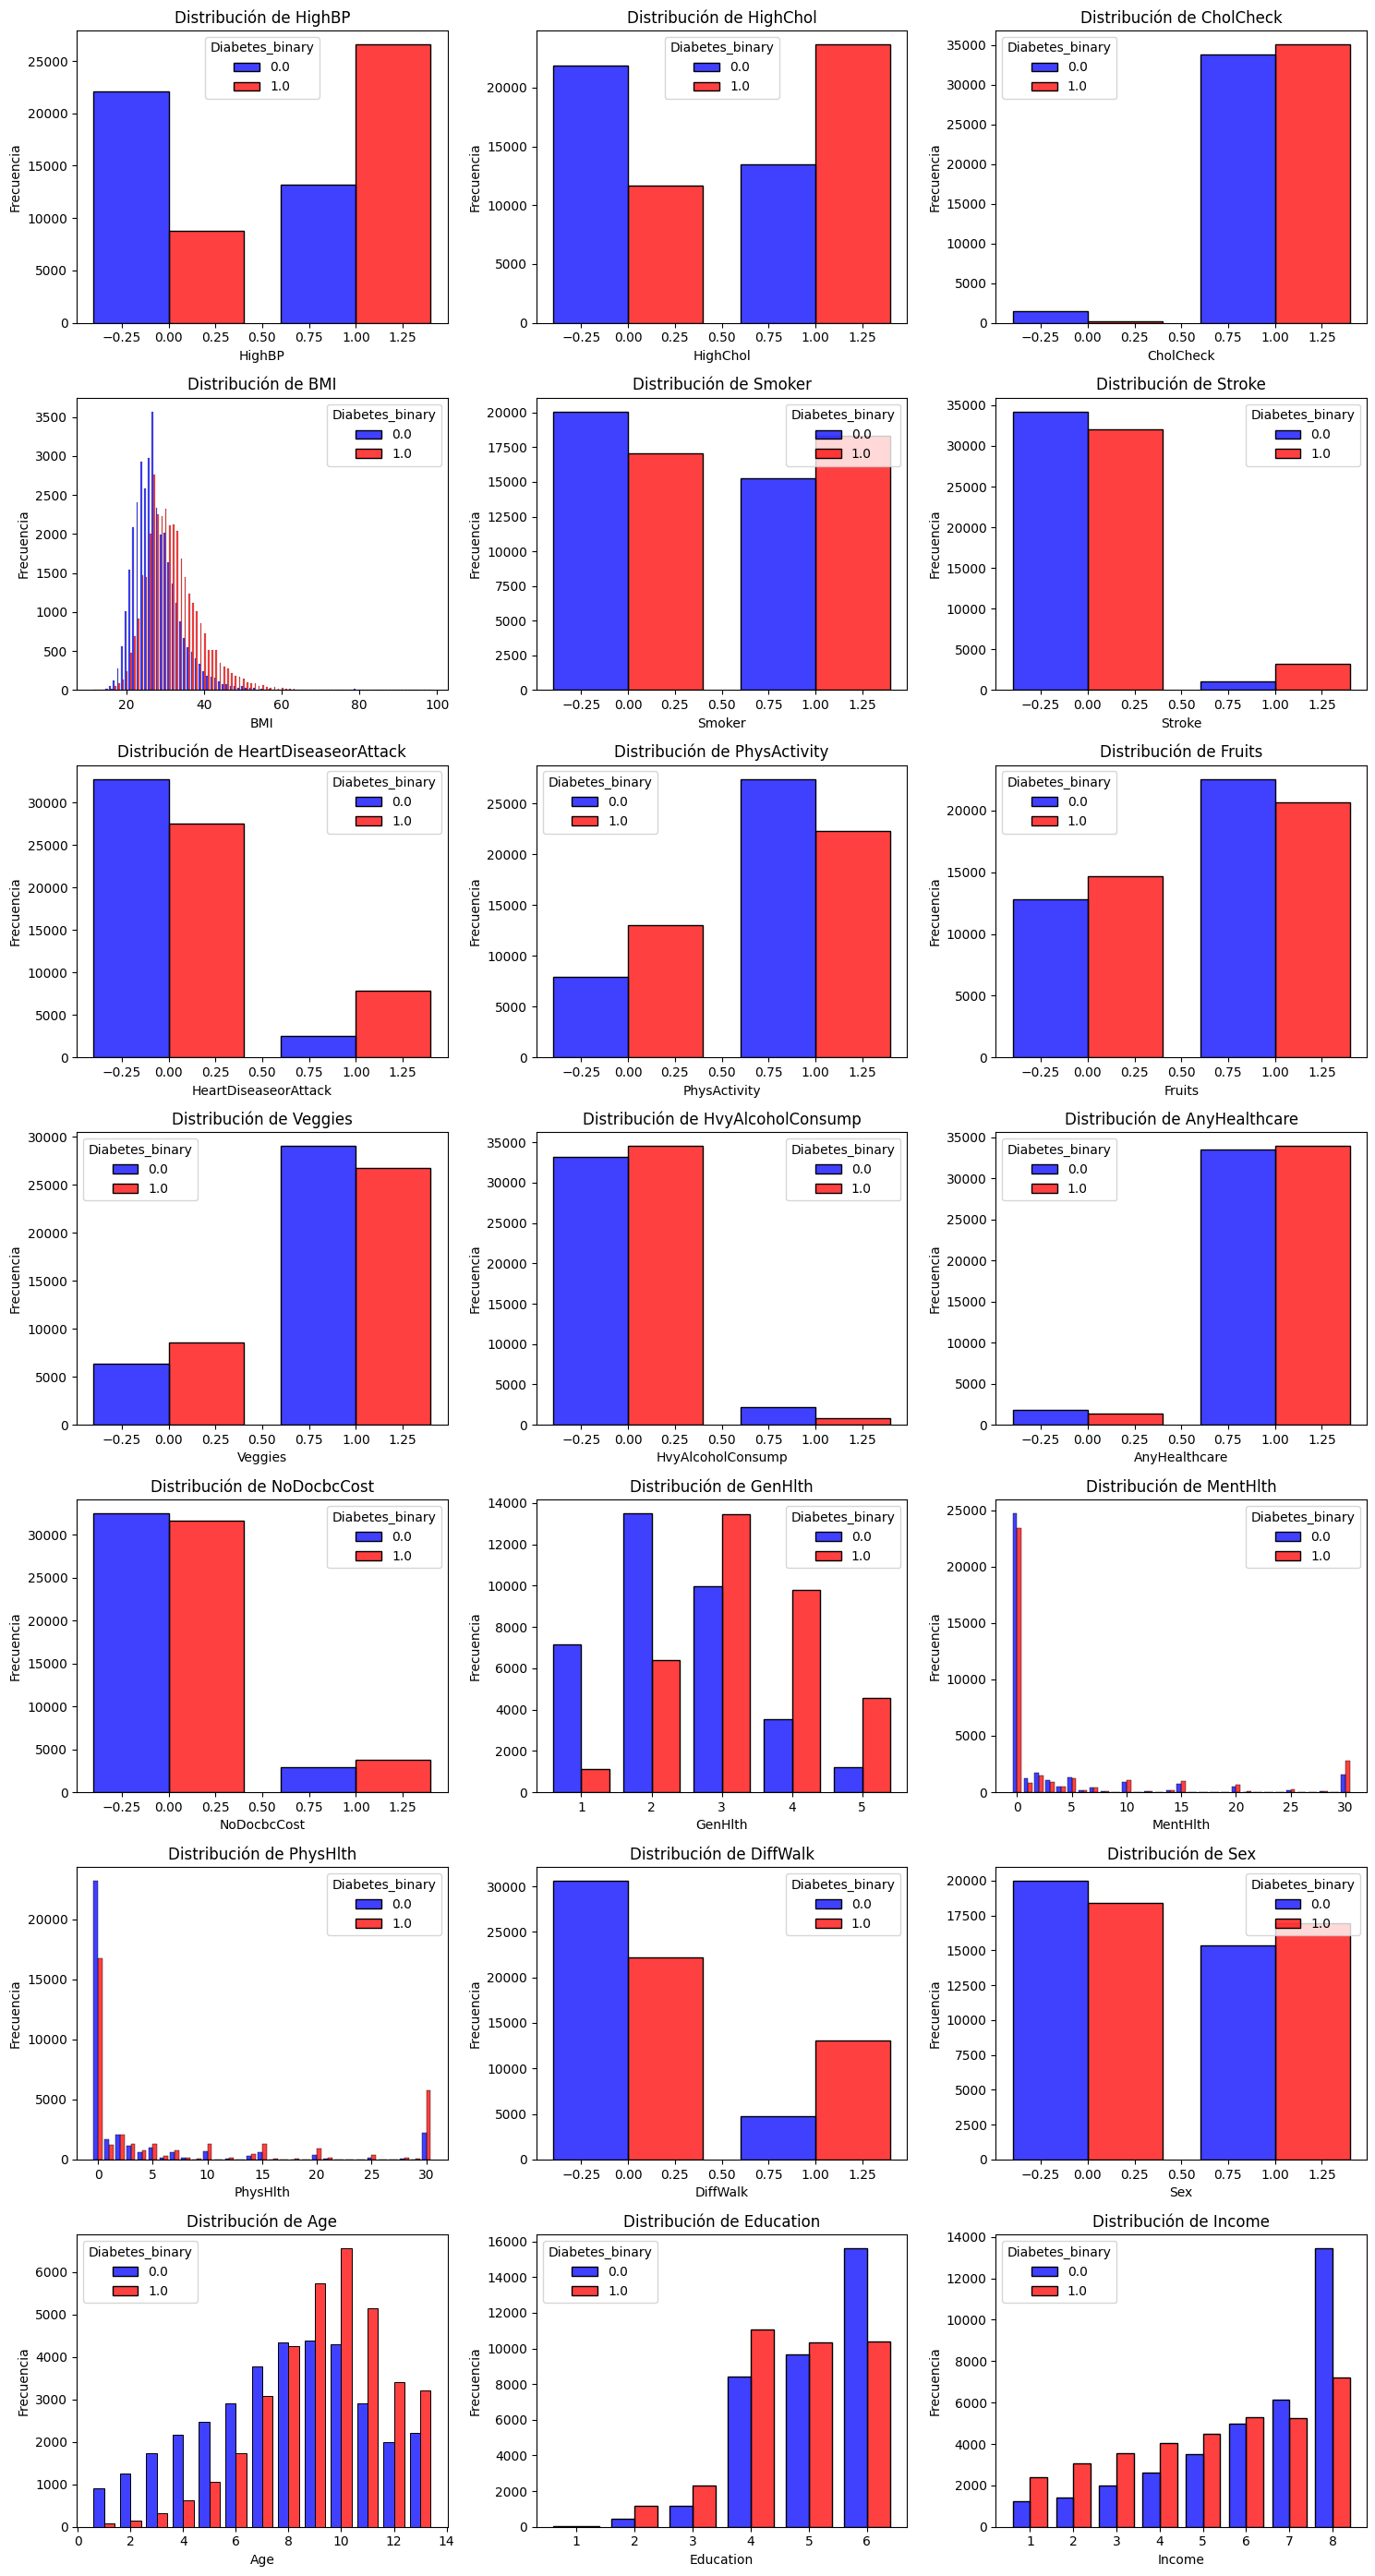

In [54]:
# 1. Matriz de Distribuciones (Histogramas)
# Seleccionamos las columnas numéricas (en este dataset todas lo son)
features = X.columns
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# Definimos colores consistentes con las gráficas SVM (Azul=No Diabetes, Rojo=Diabetes)
# Asumimos que 0 es la primera clase (Azul) y 1 la segunda (Rojo)
custom_palette = ["blue", "red"]

for i, col in enumerate(features):
    # Usamos discrete=True porque la mayoría de variables en BRFSS son categóricas/ordinales
    # Usamos multiple="dodge" para poner las barras una al lado de la otra y evitar solapamientos confusos
    # kde=False para quitar la línea de densidad
    sns.histplot(data=df, x=col, hue="Diabetes_binary", kde=False, ax=axes[i], 
                 palette=custom_palette, discrete=True, multiple="dodge", shrink=0.8)
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_ylabel("Frecuencia")

# Ocultar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

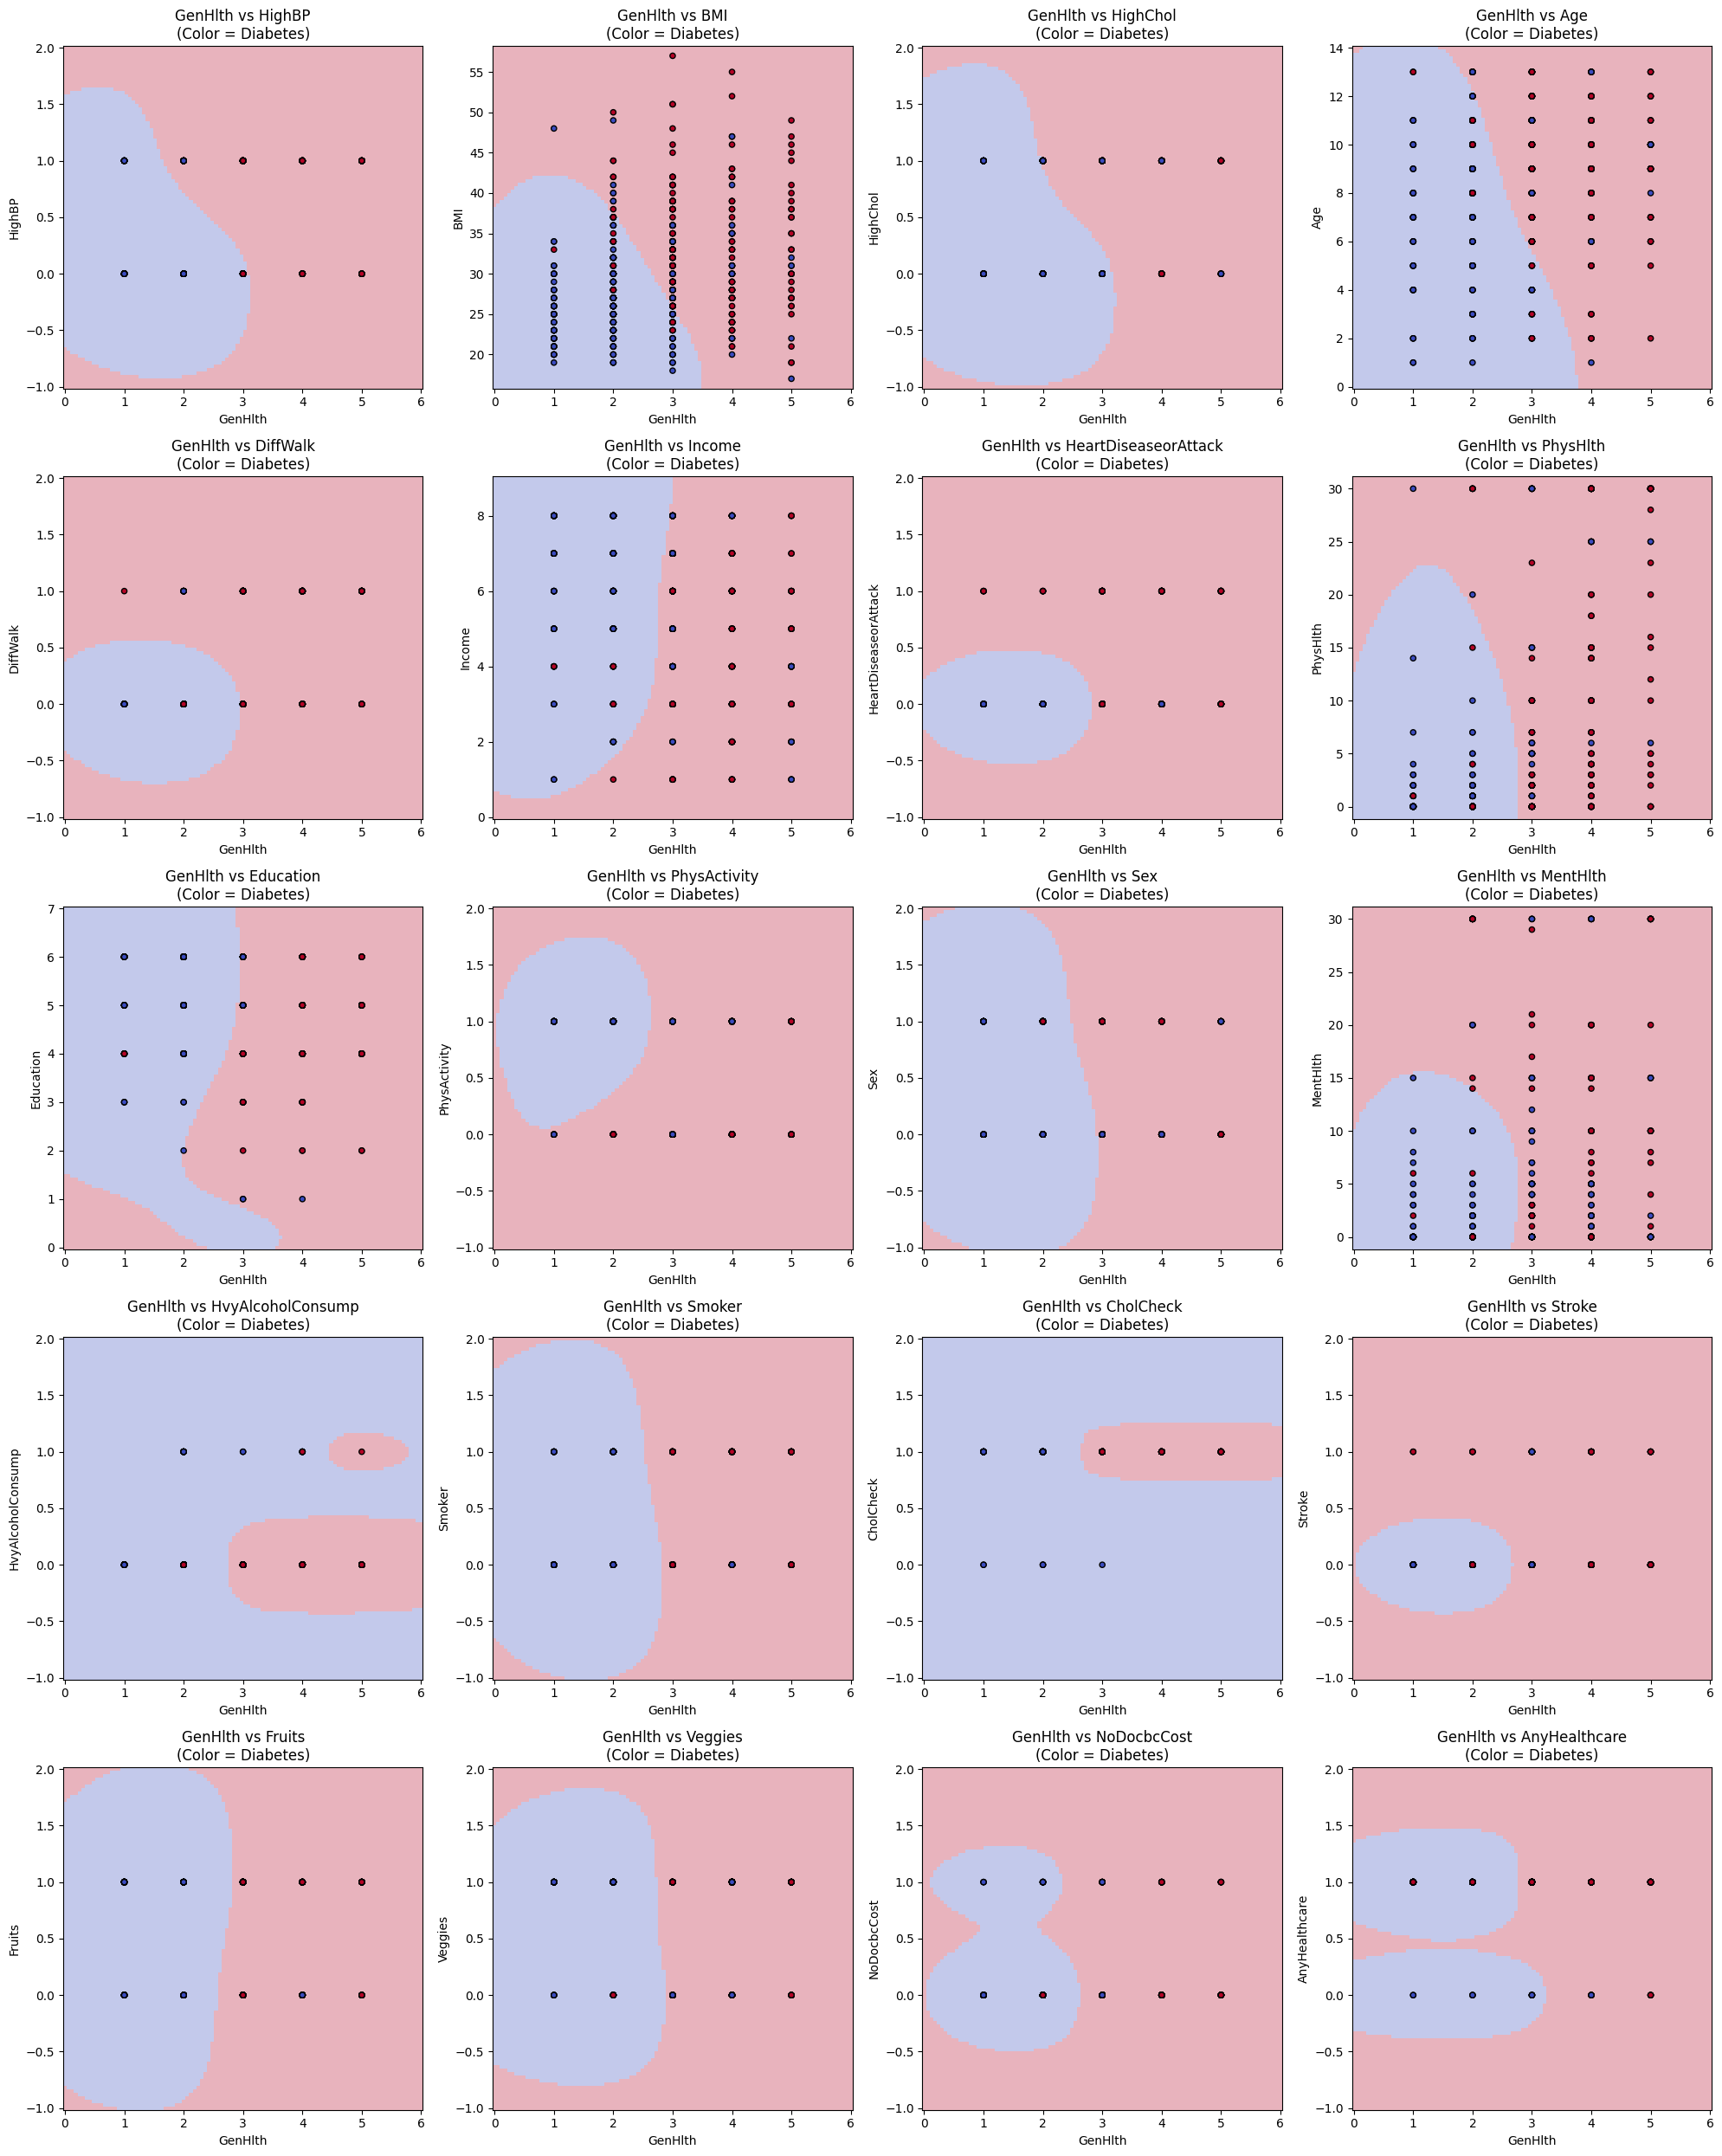

In [55]:
# 2. Matriz de Fronteras de Decisión SVM (Todas las variables)
# Dado que tenemos 21 variables, generar todos los pares posibles (210 plots) sería ilegible y muy lento.
# Estrategia: Visualizaremos la variable MÁS importante (según RF) contra TODAS las demás variables.
# Esto nos dará 20 gráficos, permitiéndonos ver cómo interactúa la variable principal con el resto.

# Paso A: Identificar las variables más importantes
# Usamos best_rf porque SVM con kernel RBF no tiene feature_importances_
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_features = X.columns[indices]

main_feature = sorted_features[0] # La variable más discriminante (eje X fijo)
other_features = sorted_features[1:] # El resto de variables (eje Y variable)

# Paso B: Configurar la matriz de gráficos
n_plots = len(other_features)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Usamos los mejores hiperparámetros encontrados en el modelo SVM
C_opt = best_svm.C
gamma_opt = best_svm.gamma
kernel_opt = best_svm.kernel

for i, feat2 in enumerate(other_features):
    ax = axes[i]
    feat1 = main_feature
    
    # Preparamos datos 2D (usamos una muestra para no saturar el plot y acelerar el entrenamiento de los 20 SVMs)
    # Tomamos 500 puntos aleatorios para visualizar
    sample_idx = np.random.choice(X_train.index, size=500, replace=False)
    X_2d = X_train.loc[sample_idx, [feat1, feat2]]
    y_2d = y_train.loc[sample_idx]
    
    # Entrenamos SVM 2D para este par específico
    clf_2d = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(C=C_opt, gamma=gamma_opt, kernel=kernel_opt))
    ])
    clf_2d.fit(X_2d, y_2d)
    
    # Plot Decision Boundary
    DecisionBoundaryDisplay.from_estimator(
        clf_2d,
        X_2d,
        plot_method="pcolormesh",
        shading="auto",
        alpha=0.3,
        cmap=plt.cm.coolwarm,
        ax=ax,
        response_method="predict"
    )
    
    # Plot de los puntos
    ax.scatter(X_2d.iloc[:, 0], X_2d.iloc[:, 1], c=y_2d, cmap=plt.cm.coolwarm, edgecolors="k", s=20)
    ax.set_title(f"{feat1} vs {feat2}\n(Color = Diabetes)")
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)

# Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Análisis de Resultados y Conclusiones

## Comparativa de Modelos

A continuación se presenta la tabla comparativa con los resultados obtenidos en el conjunto de test para los tres modelos optimizados:

| Modelo               | Accuracy Test | Error Test | Hiperparámetros                                          |
|----------------------|---------------|------------|----------------------------------------------------------------|
| **Random Forest**     | 0.7490        | 0.2510     | `max_depth`: 20, `min_samples_leaf`: 40, `n_estimators`: 300   |
| **Boosting** | **0.7537** | **0.2463** | `learning_rate`: 0.1, `max_iter`: 50, `max_leaf_nodes`: 31, `early_stopping`: True |
| **SVM**               | 0.7376        | 0.2624     | `C`: 0.1, `gamma`: 'scale', `kernel`: 'rbf'                    |

## Conclusiones

1.  **Mejor Algoritmo**: El algoritmo que ha funcionado mejor para este problema es **Gradient Boosting Classifier**, ya que ha alcanzado el mayor accuracy (**75.37%**) y el menor error de test (**24.63%**). Aunque la diferencia con SVM y Random Forest es el más adecuado para este dataset.

2.  **Sobre el algoritmo Boosting**:
    * **Boosting** es una técnica que combina varios modelos más simples (por lo general, árboles de decisión pequeños). En lugar de entrenar los modelos de forma independiente, como en el caso de Random Forest, **Boosting** entrena modelos de manera secuencial. Cada nuevo modelo se ajusta para corregir los errores cometidos por el modelo anterior. 
    * **Manejo de variables categóricas**: En este problema, las variables del dataset son principalmente **categóricas** (Aunque se nos den ya transformadas a valores numéricos). Estas se nos han dado transformadas a escalas numéricas para ser procesadas por los algoritmos de Machine Learning. Sin embargo, la transformación de variables categóricas a variables numéricas puede afectar la precisión de algunos modelos, especialmente aquellos que no están diseñados para manejar relaciones no lineales o la distribución de las categorías de manera efectiva.
    * El **Gradient Boosting Classifier** demuestra ser ligermente mejor a los otros dos modelos tratando variables de este estilo. No obstante, podríamos concluir que es por esta razón por la que obtenemos una precisión en estos modelos un poco baja.

3. Respondiendo a la pregunta ```¿Hasta qué punto es posible predecir la diabetes, a partir de los hábitos del sujeto?```. Vemos que a partir de los hábitos del sujeto se puede predecir la diabetes razonablemente bien.